## Single Mouse GMM M-step

Drafting code to be used across `mouse.single_mouse_gmm` for parameter inference.

Current problem: M step fits a tight distribution around some point near but not at the component mean. $\pi$ is also fit incorrectly.

### Setup

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [124]:
from kpsn.models.single_mouse_gmm.model import *
from kpsn.models.single_mouse_gmm.inference import gaussian_product, objective
import kpsn.models.single_mouse_gmm.test_data as smgmm_test
from kpsn import util

from mph.generative.test.visualize import mixtures

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np
import optax
import jax
from tensorflow_probability.substrates import jax as tfp
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Drafting

In [318]:
smgmm_data = smgmm_test.sample(
    jr.PRNGKey(1),
    smgmm_test.ExampleSMGMMArch,
    smgmm_test.ExampleSMGMMHyperparams,
    **smgmm_test.ExampleSMGMMDatasetParams
)

Reloading 'kpsn.models.single_mouse_gmm.inference'.


In [319]:

def step_loss(
    params: optax.Params, 
    estimated_params: SingleMouseGMMParameters,
    emissions: SingleMouseGMMObservables,
    hyperparams: SingleMouseGMMHyperparams
    ) -> Scalar:

    return -objective(params, estimated_params, emissions, hyperparams)

def mstep(
    init_params: optax.Params,
    estimated_params: SingleMouseGMMParameters,
    emissions: SingleMouseGMMObservables,
    hyperparams: SingleMouseGMMHyperparams,
    optimizer: optax.GradientTransformation,
    n_steps: int,
    log_every: int
    ):

    @jax.jit
    def step(opt_state, params, estimated_params, emissions, hyperparams):
        loss_value, grads = jax.value_and_grad(step_loss, argnums = 0)(
            params, estimated_params, emissions, hyperparams)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        update_norms = SingleMouseGMMParameters(
            pibar = jnp.linalg.norm(updates.pibar),
            m = jnp.linalg.norm(updates.m),
            lq = jnp.linalg.norm(updates.lq)
        )
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value, update_norms

    curr_params = init_params
    opt_state = optimizer.init(init_params)
    loss_hist = np.empty([n_steps])
    update_norms_hist = np.empty([smgmm_test.ExampleSMGMMArch.N, smgmm_test.ExampleSMGMMArch.M, n_steps])
    for step_i in range(n_steps):
        curr_params, opt_state, loss_value, update_norms = step(
            opt_state, curr_params,
            estimated_params, emissions, hyperparams)
        loss_hist[step_i] = loss_value
        update_norms_hist[..., step_i] = abs(jnp.linalg.eigvals(curr_params.Q()))
        
        if (log_every > 0) and (not step_i % log_every):
            print(f"Step {step_i} : loss = {loss_value}")

    return loss_hist, update_norms_hist, curr_params


In [320]:
loss_hist, update_norms_hist, fit_params = mstep(
    # init_params = smgmm_test.pertub_parameters(jr.PRNGKey(1), smgmm_data.params, 0.0),
    # estimated_params = smgmm_test.pertub_parameters(jr.PRNGKey(0), smgmm_data.params, 0.0),
    init_params = smgmm_data.params,
    estimated_params = smgmm_data.params,
    emissions = smgmm_data.observables,
    hyperparams = smgmm_data.hyperparams,
    optimizer = optax.adam(learning_rate=5e-4),
    n_steps = 2000,
    log_every = -1
)

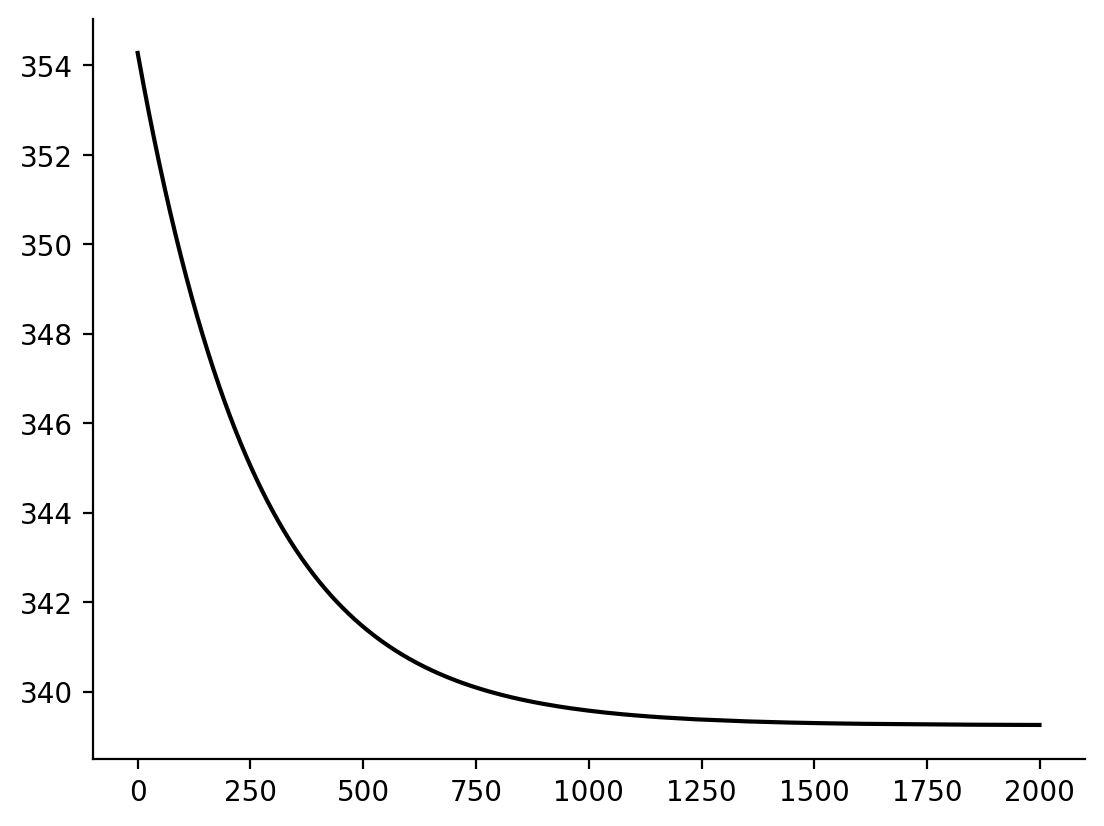

In [321]:
plt.plot(loss_hist, 'k-')
sns.despine()

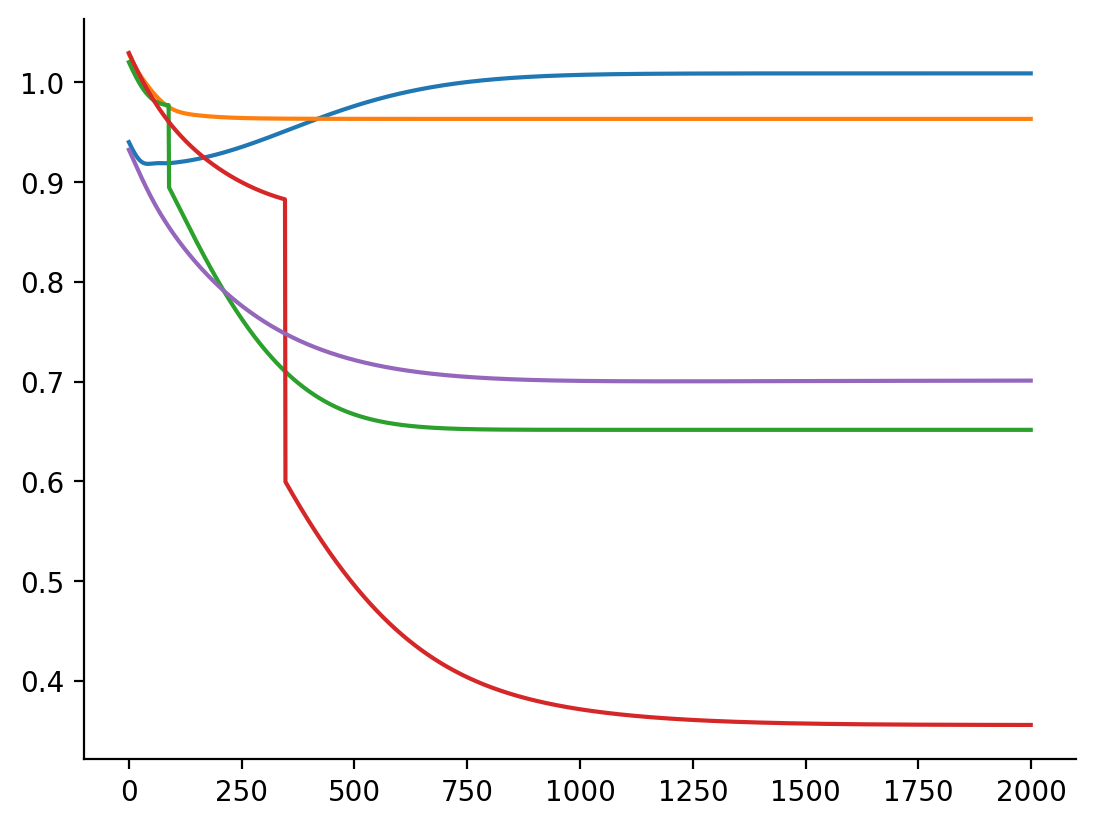

In [325]:
plt.plot(update_norms_hist[:, 1, :].T)
# plt.yscale('log')
sns.despine()

### Plotting

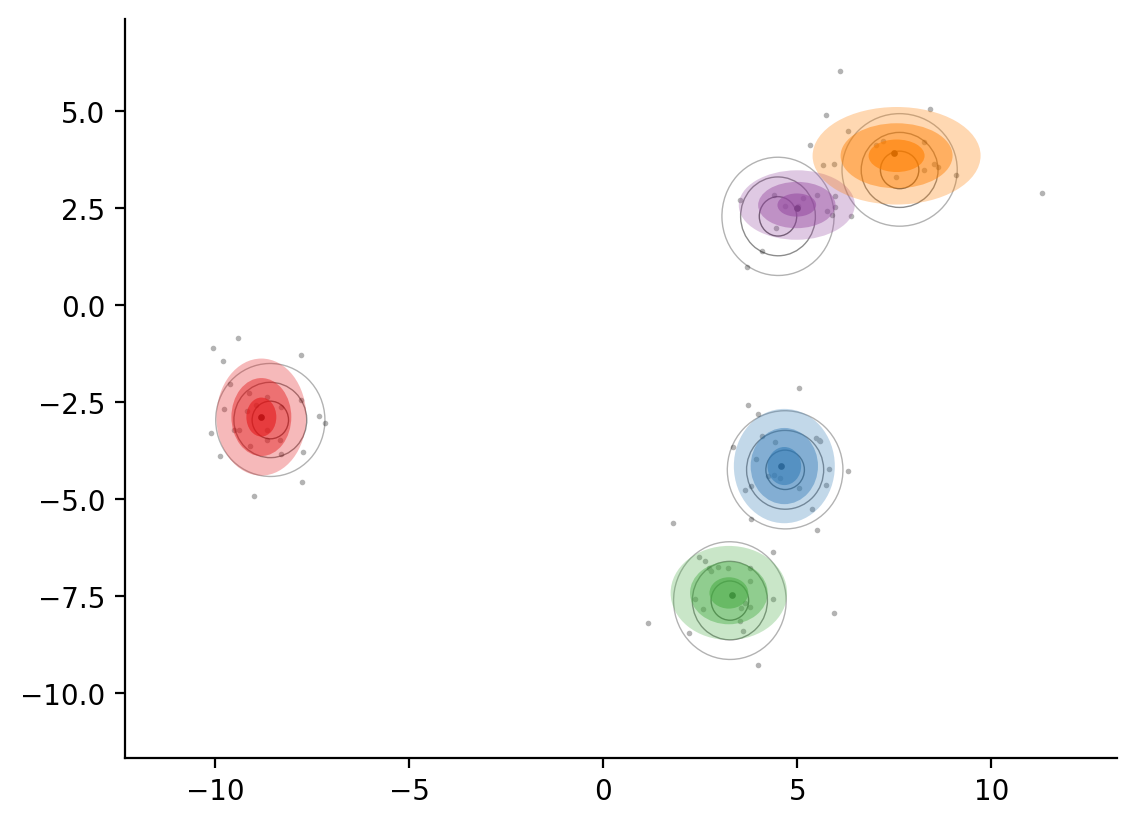

In [323]:
true_params = smgmm_data.params
# perturb_params = smgmm_test.pertub_parameters(jr.PRNGKey(1), smgmm_data.params, 0.1)
compare_params = fit_params
true_means = jnp.array([
    smgmm_data.observables.y[smgmm_data.latents.z == i].mean(axis = 0)
    for i in range(len(smgmm_data.params.m))])

fig, ax = plt.subplots()

ax.scatter(
    x = smgmm_data.observables.y[:, 0], y = smgmm_data.observables.y[:, 1],
    s = 1, color = '.7'
)
ax.scatter(
    x = true_means[:, 0], y = true_means[:, 1],
    s = 2, color = 'k'
)

mixtures.apply_vrng(ax, mixtures.plot_cov_ellipses_comparison(
    true_params.m, true_params.Q(),
    compare_params.m, compare_params.Q(),
    ax = ax,
    alpha_range = (0.6, 0.3)
))

sns.despine(ax=ax)
plt.show()
    

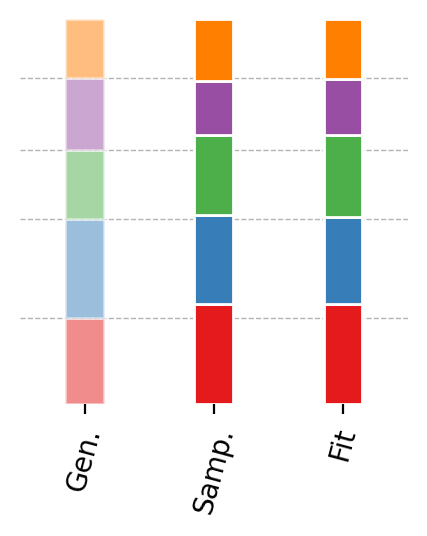

In [324]:
true_params = smgmm_data.params
compare_params = fit_params
empirical_pi = jnp.histogram(
    smgmm_data.latents.z,
    jnp.arange(len(smgmm_data.params.m)+1) - 0.5,
    density = True)[0]

fig, ax = plt.subplots(figsize = (2.5, 2.5))
mixtures.compare_dirichlet_blocks(
    true_params.pi(), [empirical_pi,  fit_params.pi()], ax, labels = ['Gen.', "Samp.", "Fit"]
)

### Debugging

Aim to compute a couple of intermediates along the way that are more interpretable than the loss function itself.

##### Gaussian product

Reloading 'kpsn.models.single_mouse_gmm.inference'.


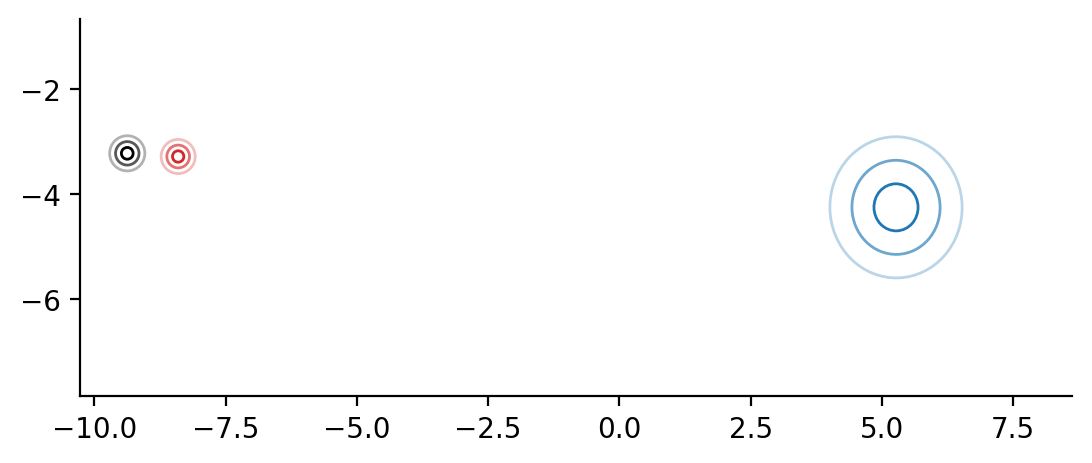

In [129]:
query_params = smgmm_test.pertub_parameters(jr.PRNGKey(1), smgmm_data.params, 0.1)
estimated_params = smgmm_test.pertub_parameters(jr.PRNGKey(0), smgmm_data.params, 0.1)
y = smgmm_data.observables.y

t = 5
z = 1
obs_color = 'k'
est_color = 'C0'
cbn_color = 'C3'

M = estimated_params.m.shape[-1]
R_star = (smgmm_data.hyperparams.eps * jnp.eye(M))
mu_star, sigma_star, prob_obs_given_z = gaussian_product(
    y, estimated_params.m, estimated_params.Q(), R_star)

fig, ax = plt.subplots()

# ax.plot([y[t, 0]], [y[t, 1]], 'o', color = obs_color)
_, vrng1 = mixtures.fading_cov_ellipses(
    y[t], R_star,
    ec = obs_color, ax = ax)
_, vrng2 = mixtures.fading_cov_ellipses(
    estimated_params.m[z], estimated_params.Q()[z],
    ec = est_color, ax = ax)
_, vrng3 = mixtures.fading_cov_ellipses(
    mu_star[t, z], sigma_star[z],
    ec = cbn_color, ax = ax)

mixtures.apply_vrng(ax, mixtures.combine_vrng(vrng1, vrng2, vrng3))
sns.despine(ax=ax)
plt.show()

In [164]:
T, N = 7, 5
y = np.random.randn(T, 1); m_star = np.random.randn(N, 1)
R_star = 0.5 * abs(np.random.randn(1, 1)); Q_star = 0.5 * abs(np.random.randn(N, 1, 1))

mu_star, sigma_star, prob_obs_given_z = gaussian_product(
    y, m_star, Q_star, R_star)

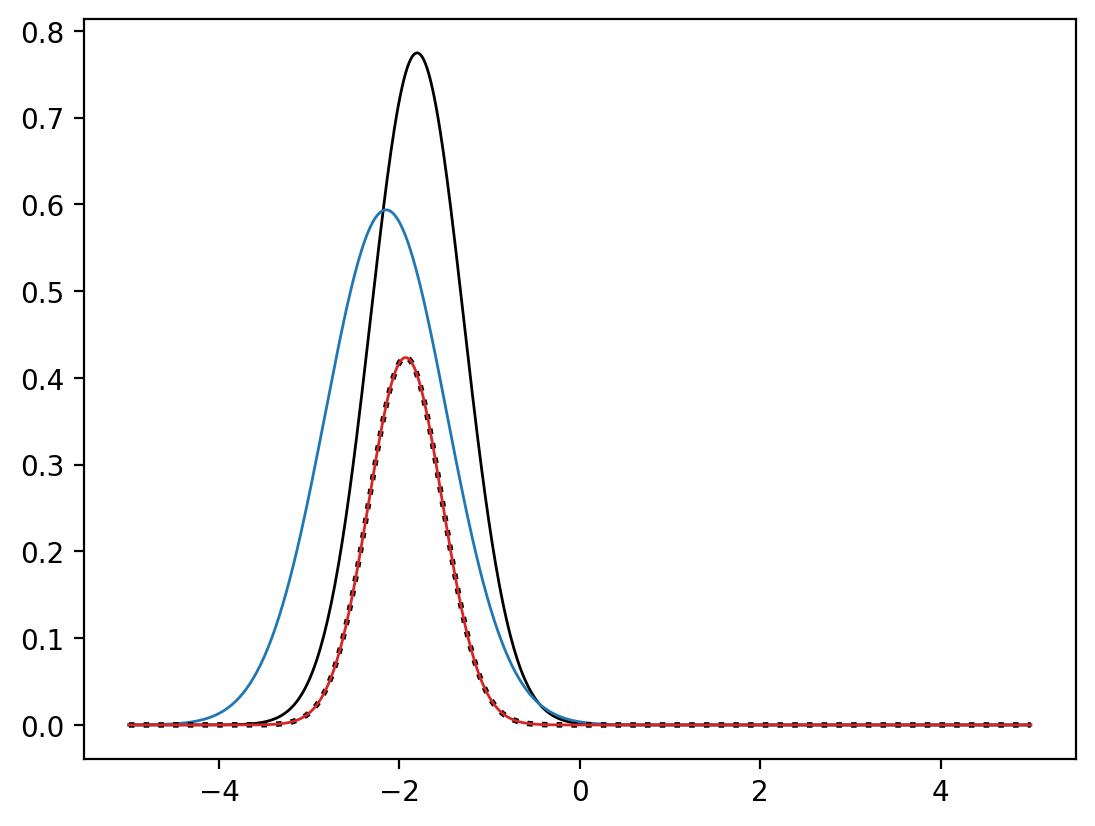

In [198]:
t = 4; z = 1
plot_lim = 5
query_x = np.linspace(-plot_lim, plot_lim, 500)

obs_dist = tfp.distributions.Normal(loc = y[t, 0], scale = np.sqrt(R_star[0, 0])).prob(query_x)
est_dist = tfp.distributions.Normal(loc = m_star[z, 0], scale = np.sqrt(Q_star[z, 0, 0])).prob(query_x)
cbn_dist = tfp.distributions.Normal(loc = mu_star[t, z, 0], scale = np.sqrt(sigma_star[z, 0, 0])).prob(query_x)

fig, ax = plt.subplots()
plt.plot(query_x, obs_dist, '-', lw = 1, color = obs_color)
plt.plot(query_x, est_dist, '-', lw = 1, color = est_color)
plt.plot(query_x, obs_dist * est_dist, ':', lw = 2, color = obs_color)
plt.plot(query_x, prob_obs_given_z[t, z] * cbn_dist, '-', lw = 1, color = cbn_color)

plt.show()

##### Sampled integral

In [264]:
n_samp = 1000
query_params = smgmm_test.pertub_parameters(jr.PRNGKey(1), smgmm_data.params, 0.1)
estimated_params = smgmm_test.pertub_parameters(jr.PRNGKey(0), smgmm_data.params, 0.1)
y = smgmm_data.observables.y
key = jr.split(jr.PRNGKey(0), 2)

M = estimated_params.m.shape[-1]
R_star = (smgmm_data.hyperparams.eps * jnp.eye(M))
mu_star, sigma_star, prob_obs_given_z = gaussian_product(
    y, estimated_params.m, estimated_params.Q(), R_star)

# P(y_t|theta^*) normalizing factor omitted, since interested in
# the same number of samples for each time point
# z_weights: Float[Array, "T N"] = (
#     estimated_params.pi()[None, :]
#     * prob_obs_given_z)

# n_per_component = tfp.distributions.Multinomial(
#     total_count = n_samp,
#     probs = z_weights / z_weights.sum(axis = -1, keepdims = True)
# ).sample(seed = key[0])
normal_samples = tfp.distributions.MultivariateNormalFullCovariance(
    loc = mu_star,
    covariance_matrix = sigma_star[None, z]
).sample(n_samp, seed = key[1])

# q_sampled = np.empty(n_per_component.shape, dtype = 'object')
# for t in range(n_per_component.shape[0]):
#     for z in range(n_per_component.shape[1]):
#         q_sampled[t, z] = normal_samples[:int(n_per_component[t, z]), t, z]


Component 1: 867 samples.
Component 2: 133 samples.


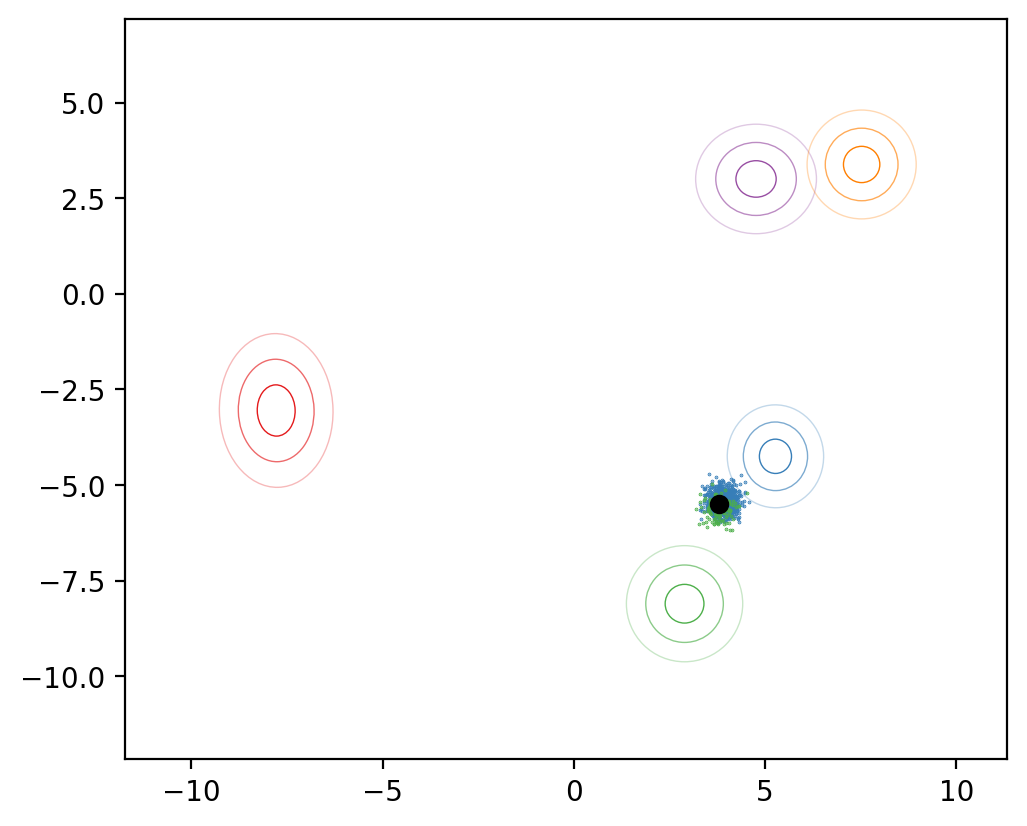

In [263]:
# Plot resulting q_t(x, z)
t = 15

pal = sns.color_palette("Set1", n_colors = len(estimated_params.m))

fig, ax = plt.subplots()

vrng = mixtures.plot_many_fading_cov_ellipses(
        estimated_params.m, estimated_params.Q(),
        pal = pal, ax = ax,
        **{'lw': 0.5,})

for z in range(len(estimated_params.m)):
    if q_sampled[t, z].shape[0] > 0:
        print(f"Component {z}: {q_sampled[t, z].shape[0]} samples.")
    ax.scatter(
        q_sampled[t, z][:, 0], q_sampled[t, z][:, 1],
        color = pal[z], s = 0.1)
ax.plot([y[t, 0]], [y[t, 1]], 'ko')

mixtures.apply_vrng(ax, vrng)
plt.show()

In [268]:
obs_term:   Float[Array, "n_samp T N"] = tfp.distributions.MultivariateNormalFullCovariance(
    loc = y[:, None],
    covariance_matrix = R_star[None, None]
).log_prob(normal_samples).mean(axis = 0)
clust_term: Float[Array, "n_samp T N"] = tfp.distributions.MultivariateNormalFullCovariance(
    loc = query_params.m,
    covariance_matrix = query_params.Q
).log_prob(normal_samples).mean(axis = 0)

In [271]:
_, obj_terms = objective(query_params, estimated_params, smgmm_data.observables, smgmm_data.hyperparams)

Reloading 'kpsn.models.single_mouse_gmm.inference'.


In [ ]:
logtwopi_term = estimated_params.m.shape[-1] / 2 * jnp.log(2 * jnp.pi)


##### Zero-noise limit in single cluster
